In [ ]:
!wget https://www.gutenberg.org/files/2701/old/moby10b.txt

--2024-05-08 04:22:24--  https://www.gutenberg.org/files/2701/old/moby10b.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1256167 (1.2M) [text/plain]
Saving to: ‘moby10b.txt.4’

moby10b.txt.4       100%[===================>]   1.20M  3.37MB/s    in 0.4s    

2024-05-08 04:22:25 (3.37 MB/s) - ‘moby10b.txt.4’ saved [1256167/1256167]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

In [ ]:
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

random.shuffle(letters2)

for k, v in zip(letters1, letters2):
  true_mapping[k] = v

In [ ]:
markov_matrix_3 = np.ones((26, 26, 26, 26))

markov_matrix_2 = np.ones((26, 26, 26))

markov_matrix_1 = np.ones((26, 26))

pi = np.zeros(26)

def update_transition(ch_1, ch_2=None, ch_3=None, ch_4=None):
    i = ord(ch_1) - 97
    if ch_2 is not None:
        j = ord(ch_2) - 97
        markov_matrix_1[i, j] += 1
        if ch_3 is not None:
            k = ord(ch_3) - 97
            markov_matrix_2[i, j, k] += 1
            if ch_4 is not None:
                l = ord(ch_4) - 97
                markov_matrix_3[i, j, k, l] += 1

def update_pi(ch):
  i = ord(ch) - 97
  pi[i] += 1

def get_word_prob(word):
    i = ord(word[0]) - 97
    if pi[i] == 0:
        return -1e5  # Reduced penalty for unknown starting characters

    logp = np.log(pi[i])

    if len(word) > 1:
        for idx in range(1, len(word)):
            j = ord(word[idx]) - 97
            logp += np.log(markov_matrix_1[i, j]) if markov_matrix_1[i, j] > 0 else -1e5
            i = j

    if len(word) > 2:
        for idx in range(2, len(word)):
            j = ord(word[idx - 1]) - 97
            k = ord(word[idx]) - 97
            logp += np.log(markov_matrix_2[i, j, k]) if markov_matrix_2[i, j, k] > 0 else -1e5
            i = j

    if len(word) > 3:
        for idx in range(3, len(word)):
            j = ord(word[idx - 2]) - 97
            k = ord(word[idx - 1]) - 97
            l = ord(word[idx]) - 97
            logp += np.log(markov_matrix_3[i, j, k, l]) if markov_matrix_3[i, j, k, l] > 0 else -1e5
            i = j

    return logp

def get_sequence_prob(words):
  if type(words) == str:
    words = words.split()

  logp = 0
  for word in words:
    logp += get_word_prob(word)
  return logp

In [ ]:
regex = re.compile('[^a-zA-Z]')

for line in open('/content/moby10b.txt'):
    line = line.rstrip()

    if line:
        line = regex.sub(' ', line)
        tokens = line.lower().split()

        for token in tokens:
            if len(token) >= 1:
                ch_0 = token[0]
                update_pi(ch_0)

                if len(token) >= 2:
                    for idx in range(1, len(token)):
                        ch_1 = token[idx]
                        update_transition(ch_0, ch_1)
                        ch_0 = ch_1

                if len(token) >= 3:
                    for idx in range(2, len(token)):
                        ch_1 = token[idx - 1]
                        ch_2 = token[idx]
                        update_transition(ch_0, ch_1, ch_2)
                        ch_0 = ch_1

                if len(token) >= 4:
                    for idx in range(3, len(token)):
                        ch_1 = token[idx - 2]
                        ch_2 = token[idx - 1]
                        ch_3 = token[idx]
                        update_transition(ch_0, ch_1, ch_2, ch_3)
                        ch_0 = ch_1

pi /= pi.sum()
markov_matrix_1 /= markov_matrix_1.sum(axis=1, keepdims=True)
markov_matrix_2 /= markov_matrix_2.sum(axis=(1, 2), keepdims=True)
markov_matrix_3 /= markov_matrix_3.sum(axis=(1, 2, 3), keepdims=True)

print(pi)

[1.09297400e-01 5.18139885e-02 3.89557377e-02 2.71860160e-02
 1.86773463e-02 3.85021839e-02 1.65275012e-02 6.33115779e-02
 6.70443258e-02 3.91416947e-03 4.43575637e-03 2.82337254e-02
 3.90600551e-02 2.22785637e-02 6.54568874e-02 2.85557486e-02
 3.27919413e-03 1.81194751e-02 9.23299513e-02 1.63896209e-01
 1.22822375e-02 7.44281820e-03 6.74026333e-02 4.08198439e-05
 1.17923993e-02 1.63279376e-04]


In [ ]:


original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.'''

In [ ]:
def encode_message(msg):
    msg = msg.lower()
    msg = regex.sub(' ', msg)

    coded_msg = []
    for ch in msg:
        coded_ch = ch
        if ch in true_mapping:
            coded_ch = true_mapping[ch]
        coded_msg.append(coded_ch)

    return ''.join(coded_msg)

encoded_message = encode_message(original_message)


def decode_message(msg, word_map):
    decoded_msg = []
    for ch in msg:
        decoded_ch = ch
        if ch in word_map:
            decoded_ch = word_map[ch]
        decoded_msg.append(decoded_ch)

    return ''.join(decoded_msg)

In [ ]:
def initialize_dna_pool(pool_size, num_chars):
    dna_pool = []
    for _ in range(pool_size):
        dna = random.sample(letters2, num_chars)
        dna_pool.append(dna)
    return dna_pool

def crossover(dna1, dna2):
    cut = np.random.randint(1, len(dna1) - 1)
    child1 = dna1[:cut] + [x for x in dna2 if x not in dna1[:cut]]
    child2 = dna2[:cut] + [x for x in dna1 if x not in dna2[:cut]]
    return child1, child2

In [ ]:
# Function to evolve offspring using crossover and mutation
def evolve_offspring(dna_pool, n_children, mutation_prob=0.2):
    offspring = []
    num_parents = len(dna_pool)

    # Elitism: Keep a portion of the best parents
    elite = sorted(dna_pool, key=lambda x: np.random.random())[:3]
    offspring.extend(elite)

    # Generate offspring using crossover
    for _ in range(n_children):
        parent1, parent2 = random.sample(dna_pool, 2)
        child1, child2 = crossover(parent1, parent2)
        offspring.append(child1)
        offspring.append(child2)

    # Introduce mutations
    for child in offspring:
        if np.random.random() < mutation_prob:
            j, k = np.random.choice(len(child), 2, replace=False)
            child[j], child[k] = child[k], child[j]

    return offspring

In [ ]:
# Genetic algorithm with early stopping
num_iters = 100000
early_stop_patience = 1000  # Stop after 10 iterations with no improvement
no_improvement_count = 0
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
previous_best_score = float('-inf')

# Initialize the DNA pool
dna_pool = initialize_dna_pool(40, len(letters2))

for i in range(num_iters):
    if i > 0:
        dna_pool = evolve_offspring(dna_pool, 10, mutation_prob=0.2)

    dna2score = {}
    for dna in dna_pool:
        current_map = dict(zip(letters1, dna))
        decoded_message = decode_message(encoded_message, current_map)
        score = get_sequence_prob(decoded_message)

        dna2score[''.join(dna)] = score

        if score > best_score:
            best_dna = dna
            best_map = current_map
            best_score = score

    scores[i] = np.mean(list(dna2score.values()))

    sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
    dna_pool = [list(k) for k, v in sorted_dna[:10]]

    if i % 200 == 0:
        print(f"iter: {i}, score: {scores[i]}, best so far: {best_score}")

    # Early stopping condition
    if best_score == previous_best_score:
        no_improvement_count += 1
    else:
        no_improvement_count = 0  # Reset the counter if improvement is seen

    previous_best_score = best_score

    if no_improvement_count >= early_stop_patience:
        print(f"Early stopping at iteration {i} with best score {best_score}")
        break

# Output the best mapping found
print(best_map)

iter: 0, score: -5221.360687706185, best so far: -4811.381303295718
iter: 200, score: -4022.1237748924727, best so far: -3786.348360097158
iter: 400, score: -3733.9853648051335, best so far: -3430.22973534529
iter: 600, score: -4113.252823898151, best so far: -3430.22973534529
iter: 800, score: -3887.101816906314, best so far: -3430.22973534529
iter: 1000, score: -3303.6510893462573, best so far: -3068.1250083416153
iter: 1200, score: -3669.8113294823947, best so far: -3048.4306846869135
iter: 1400, score: -4187.551460624831, best so far: -3048.4306846869135
iter: 1600, score: -3917.0324168650072, best so far: -3048.4306846869135
iter: 1800, score: -3883.915632080538, best so far: -3048.4306846869135
iter: 2000, score: -4169.219788061865, best so far: -3048.4306846869135
Early stopping at iteration 2017 with best score -3048.4306846869135
{'a': 'q', 'b': 't', 'c': 'd', 'd': 'j', 'e': 'w', 'f': 'z', 'g': 'k', 'h': 'x', 'i': 'y', 'j': 'm', 'k': 'g', 'l': 's', 'm': 'e', 'n': 'o', 'o': 'p'

In [ ]:
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))


for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -3048.4306846869135
LL of true message: -2838.085059479013
true: c, pred: g
true: g, pred: c
true: j, pred: z
true: k, pred: j
true: m, pred: k
true: p, pred: m
true: z, pred: p


In [ ]:
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounced down the street and found  as i exmegted  that there
was a kews in a lane whigh runs down by one wall of the carden  i lent
the ostlers a hand in rubbinc down their horses  and regeived in
exghance twomenge  a class of half and half  two fills of shac tobaggo
and as kugh inforkation as i gould desire about kiss adler  to say
nothinc of half a dopen other meomle in the neichbourhood in whok i
was not in the least interested  but whose biocramhies i was gokmelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

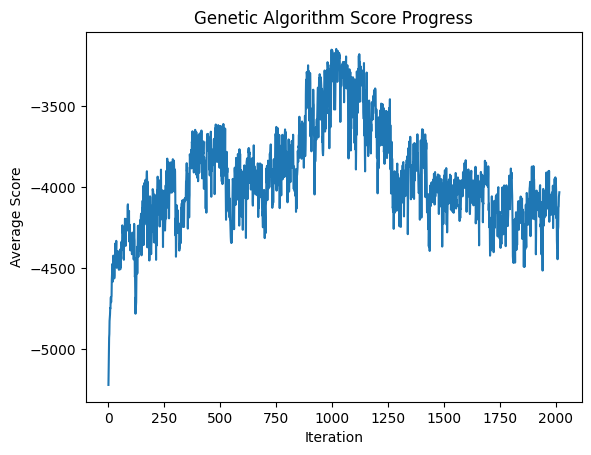

In [ ]:
plt.plot(scores[:i+ 1])
plt.xlabel('Iteration')
plt.ylabel('Average Score')
plt.title('Genetic Algorithm Score Progress')
plt.show()